# Installers & imports

In [ ]:
!pip uninstall -y numpy
!pip install --no-cache-dir numpy==1.26.4


Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4


ERROR: Could not find a version that satisfies the requirement numpy==1.26.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.21.2, 1.21.3, 1.21.4, 1.21.5, 1.21.6, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0, 1.23.1, 1.23.2, 1.23.3, 1.23.4, 1.23.5, 1.24.0, 1.24.1, 1.24.2, 1.24.3, 1.24.4)
ERROR: No matching distribution found for numpy==1.26.4


In [ ]:
!pip install numpy==1.24.4 monai==0.9.0 elasticdeform nibabel tensorboard tensorboardX \
    ml-collections einops timm opencv-python scipy tqdm matplotlib pandas glob2 --quiet

In [ ]:
!pip install surface-distance

In [ ]:
# Standard library
import os
import gc
import json
import random
from pathlib import Path
from typing import Mapping, Hashable, Dict
from functools import partial

# Third-party
import numpy as np
import cv2
import torch
import nibabel as nib
import elasticdeform
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter, zoom
import scipy.ndimage
from surface_distance import compute_surface_distances, compute_surface_dice_at_tolerance

# MONAI
import monai
from monai.config import KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.utils import one_hot
from monai.networks.nets import UNet
from monai.transforms import (
    MapTransform, RandomizableTransform, Compose, LoadImaged, AddChanneld,
    Orientationd, Spacingd, ScaleIntensityRanged, SpatialPadd,
    RandCropByPosNegLabeld, RandFlipd, RandRotate90d,
    RandScaleIntensityd, RandShiftIntensityd, ToTensord,
    CropForegroundd, RandSpatialCropd, NormalizeIntensityd,
    AsDiscrete, ResizeWithPadOrCropd, DivisiblePadd
)

# Optimizers
from torch.optim import AdamW

# Tumor Generation

## 1 - Location selection

In [ ]:
# Random select (numbers) location for tumor.
def random_select(mask_scan):
    # we first find z index and then sample point with z slice
    z_start, z_end = np.where(np.any(mask_scan, axis=(0, 1)))[0][[0, -1]]

    # we need to strict number z's position (0.3 - 0.7 in the middle of liver)
    z = round(random.uniform(0.3, 0.7) * (z_end - z_start)) + z_start

    liver_mask = mask_scan[..., z]

    # erode the mask (we don't want the edge points)
    kernel = np.ones((5,5), dtype=np.uint8)
    liver_mask = cv2.erode(liver_mask, kernel, iterations=1)

    coordinates = np.argwhere(liver_mask == 1)
    random_index = np.random.randint(0, len(coordinates))
    xyz = coordinates[random_index].tolist() # get x,y
    xyz.append(z)
    potential_points = xyz

    return potential_points

## 2 - Texture Generation

In [ ]:
# Get predefined texture:
def get_predefined_texture(mask_shape, sigma_a, sigma_b):
    # uniform noise generate
    a = np.random.uniform(0, 1, size=(mask_shape[0],mask_shape[1],mask_shape[2]))
    a_2 = gaussian_filter(a, sigma=sigma_a)
    scale = np.random.uniform(0.19, 0.21)
    base = np.random.uniform(0.04, 0.06)
    a =  scale * (a_2 - np.min(a_2)) / (np.max(a_2) - np.min(a_2)) + base

    # sample once
    random_sample = np.random.uniform(0, 1, size=(mask_shape[0],mask_shape[1],mask_shape[2]))
    b = (a > random_sample).astype(float)  
    b = gaussian_filter(b, sigma_b)

    # Scaling and clipping
    u_0 = np.random.uniform(0.5, 0.55)
    threshold_mask = b > 0.12
    beta = u_0 / (np.sum(b * threshold_mask) / threshold_mask.sum())
    Bj = np.clip(beta*b, 0, 1) 

    return Bj


## 3 - Shape generation

In [ ]:
def get_ellipsoid(x, y, z):
    """"
    x, y, z is the radius of this ellipsoid in x, y, z direction respectly.
    """
    sh = (4*x, 4*y, 4*z)
    out = np.zeros(sh, int)
    aux = np.zeros(sh)
    radii = np.array([x, y, z])
    com = np.array([2*x, 2*y, 2*z])  # center point

    # calculate the ellipsoid
    bboxl = np.floor(com-radii).clip(0,None).astype(int)
    bboxh = (np.ceil(com+radii)+1).clip(None, sh).astype(int)
    roi = out[tuple(map(slice,bboxl,bboxh))]
    roiaux = aux[tuple(map(slice,bboxl,bboxh))]
    logrid = *map(np.square,np.ogrid[tuple(
            map(slice,(bboxl-com)/radii,(bboxh-com-1)/radii,1j*(bboxh-bboxl)))]),
    dst = (1-sum(logrid)).clip(0,None)
    mask = dst>roiaux
    roi[mask] = 1
    np.copyto(roiaux,dst,where=mask)

    return out



def get_fixed_geo(mask_scan, tumor_type):

    enlarge_x, enlarge_y, enlarge_z = 160, 160, 160
    geo_mask = np.zeros((mask_scan.shape[0] + enlarge_x, mask_scan.shape[1] + enlarge_y, mask_scan.shape[2] + enlarge_z), dtype=np.int8)
    tiny_radius, small_radius, medium_radius, large_radius = 4, 8, 16, 32

    if tumor_type == 'tiny':
        num_tumor = random.randint(3,10)
        for _ in range(num_tumor):
            # Tiny tumor
            x = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            y = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            z = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            sigma = random.uniform(0.5,1)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            # paste small tumor geo into test sample
            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

    if tumor_type == 'small':
        num_tumor = random.randint(3,10)
        for _ in range(num_tumor):
            # Small tumor
            x = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            y = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            z = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            sigma = random.randint(1, 2)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            # paste small tumor geo into test sample
            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo
            

    if tumor_type == 'medium':
        num_tumor = random.randint(2, 5)
        for _ in range(num_tumor):
            # medium tumor
            x = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            y = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            z = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            sigma = random.randint(3, 6)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            # paste medium tumor geo into test sample
            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo
            

    if tumor_type == 'large':
        num_tumor = random.randint(1,3)
        for _ in range(num_tumor):
            # Large tumor
            x = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            y = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            z = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            sigma = random.randint(5, 10)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            # paste small tumor geo into test sample
            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo
            

    if tumor_type == "mix":
        # tiny
        num_tumor = random.randint(3,10)
        for _ in range(num_tumor):
            # Tiny tumor
            x = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            y = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            z = random.randint(int(0.75*tiny_radius), int(1.25*tiny_radius))
            sigma = random.uniform(0.5,1)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            # paste small tumor geo into test sample
            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

        # small
        num_tumor = random.randint(5,10)
        for _ in range(num_tumor):
            # Small tumor
            x = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            y = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            z = random.randint(int(0.75*small_radius), int(1.25*small_radius))
            sigma = random.randint(1, 2)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            # paste small tumor geo into test sample
            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo
            

        # medium
        num_tumor = random.randint(2, 5)
        for _ in range(num_tumor):
            # medium tumor
            x = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            y = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            z = random.randint(int(0.75*medium_radius), int(1.25*medium_radius))
            sigma = random.randint(3, 6)

            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
            
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            # paste medium tumor geo into test sample
            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo
            

        # large
        num_tumor = random.randint(1,3)
        for _ in range(num_tumor):
            # Large tumor
            x = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            y = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            z = random.randint(int(0.75*large_radius), int(1.25*large_radius))
            sigma = random.randint(5, 10)
            geo = get_ellipsoid(x, y, z)
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,1))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(1,2))
            geo = elasticdeform.deform_random_grid(geo, sigma=sigma, points=3, order=0, axis=(0,2))
        
            point = random_select(mask_scan)
            new_point = [point[0] + enlarge_x//2, point[1] + enlarge_y//2, point[2] + enlarge_z//2]
            x_low, x_high = new_point[0] - geo.shape[0]//2, new_point[0] + geo.shape[0]//2
            y_low, y_high = new_point[1] - geo.shape[1]//2, new_point[1] + geo.shape[1]//2
            z_low, z_high = new_point[2] - geo.shape[2]//2, new_point[2] + geo.shape[2]//2

            # paste small tumor geo into test sample
            geo_mask[x_low:x_high, y_low:y_high, z_low:z_high] += geo

    geo_mask = geo_mask[enlarge_x//2:-enlarge_x//2, enlarge_y//2:-enlarge_y//2, enlarge_z//2:-enlarge_z//2]
    geo_mask = (geo_mask * mask_scan) >=1

    return geo_mask

## 4 - Post-processing

In [ ]:
def get_tumor(volume_scan, mask_scan, tumor_type, texture):
        geo_mask = get_fixed_geo(mask_scan, tumor_type)

        sigma      = np.random.uniform(1, 2)
        difference = np.random.uniform(65, 145)

        # blur the boundary
        geo_blur = gaussian_filter(geo_mask*1.0, sigma)
        abnormally = (volume_scan - texture * geo_blur * difference) * mask_scan

        abnormally_full = volume_scan * (1 - mask_scan) + abnormally
        abnormally_mask = mask_scan + geo_mask

        return abnormally_full, abnormally_mask

In [ ]:
def SynthesisTumor(volume_scan, mask_scan, tumor_type, texture):
    x_start, x_end = np.where(np.any(mask_scan, axis=(1, 2)))[0][[0, -1]]
    y_start, y_end = np.where(np.any(mask_scan, axis=(0, 2)))[0][[0, -1]]
    z_start, z_end = np.where(np.any(mask_scan, axis=(0, 1)))[0][[0, -1]]

    # shrink the boundary
    x_start, x_end = max(0, x_start+1), min(mask_scan.shape[0], x_end-1)
    y_start, y_end = max(0, y_start+1), min(mask_scan.shape[1], y_end-1)
    z_start, z_end = max(0, z_start+1), min(mask_scan.shape[2], z_end-1)

    liver_volume = volume_scan[x_start:x_end, y_start:y_end, z_start:z_end]
    liver_mask   = mask_scan[x_start:x_end, y_start:y_end, z_start:z_end]

    x_length, y_length, z_length = x_end - x_start, y_end - y_start, z_end - z_start
    start_x = random.randint(0, texture.shape[0] - x_length - 1)
    start_y = random.randint(0, texture.shape[1] - y_length - 1)
    start_z = random.randint(0, texture.shape[2] - z_length - 1)
    cut_texture = texture[start_x:start_x+x_length, start_y:start_y+y_length, start_z:start_z+z_length]


    liver_volume, liver_mask = get_tumor(liver_volume, liver_mask, tumor_type, cut_texture)
    volume_scan[x_start:x_end, y_start:y_end, z_start:z_end] = liver_volume
    mask_scan[x_start:x_end, y_start:y_end, z_start:z_end] = liver_mask

    return volume_scan, mask_scan

## 5 - Generation and Synthesis

In [ ]:
class TumorGenerated(RandomizableTransform, MapTransform):
    def __init__(self,
    keys: KeysCollection,
    prob: float = 0.1,
    tumor_prob = [0.2, 0.2, 0.2, 0.2, 0.2],
    allow_missing_keys: bool = False
    ) -> None:
        MapTransform.__init__(self, keys, allow_missing_keys)
        RandomizableTransform.__init__(self, prob)
        random.seed(0)
        np.random.seed(0)

        self.tumor_types = ['tiny', 'small', 'medium', 'large', 'mix']

        assert len(tumor_prob) == 5
        self.tumor_prob = np.array(tumor_prob)
        self.textures = []
        sigma_as = [3, 6, 9, 12, 15]
        sigma_bs = [4, 7]
        predefined_texture_shape = (420, 300, 320)
        for sigma_a in sigma_as:
            for sigma_b in sigma_bs:
                texture = get_predefined_texture(predefined_texture_shape, sigma_a, sigma_b)
                self.textures.append(texture)
        print("All predefined texture have generated.")


    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        self.randomize(None)

        if self._do_transform and (np.max(d['label']) <= 1):
            tumor_type = np.random.choice(self.tumor_types, p=self.tumor_prob.ravel())
            texture = random.choice(self.textures)
            d['image'][0], d['label'][0] = SynthesisTumor(d['image'][0], d['label'][0], tumor_type, texture)
        return d

# Dataset

In [7]:
json_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\healthy.json"
base_dir = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github"
roi_size = (96, 96, 96)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loading files and building paths
with open(json_path) as f:
    splits = json.load(f)

def add_base_path(entries):
    return [
        {
            "image": os.path.join(base_dir, item["image"]),
            "label": os.path.join(base_dir, item["label"])
        }
        for item in entries
    ]

train_files = add_base_path(splits["training"])
val_files = add_base_path(splits["validation"])

# Filtering
train_files = [f for f in train_files if Path(f["image"]).exists() and Path(f["label"]).exists()]
val_files = [f for f in val_files if Path(f["image"]).exists() and Path(f["label"]).exists()]

Using device: cuda


## Transformations

In [ ]:
train_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
            TumorGenerated(keys=["image", "label"], prob=0.9), # here we use online
            ScaleIntensityRanged(
                keys=["image"], a_min=-21, a_max=189,
                b_min=0.0, b_max=1.0, clip=True,
            ),
            SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[96, 96, 96]),
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(96, 96, 96),
                pos=1,
                neg=1,
                num_samples=1,
                image_key="image",
                image_threshold=0,
            ),
            RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=0),
            RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=1),
            RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=2),
            RandRotate90d(keys=["image", "label"], prob=0.2, max_k=3),
            RandScaleIntensityd(keys="image", factors=0.1, prob=0.15),
            RandShiftIntensityd(keys="image", offsets=0.1, prob=0.15),
            ToTensord(keys=["image", "label"]),
        ]
        )

val_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
            ScaleIntensityRanged(keys=["image"], a_min=-21, a_max=189, b_min=0.0, b_max=1.0, clip=True),
            SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[96, 96, 96]),
            ToTensord(keys=["image", "label"]),
        ]
    )
# Dataloader 
train_ds = Dataset(train_files, transform=train_transform)
val_ds = Dataset(val_files, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)


All predefined texture have generated.


#### Synthetic tumor visualization

All predefined texture have generated.


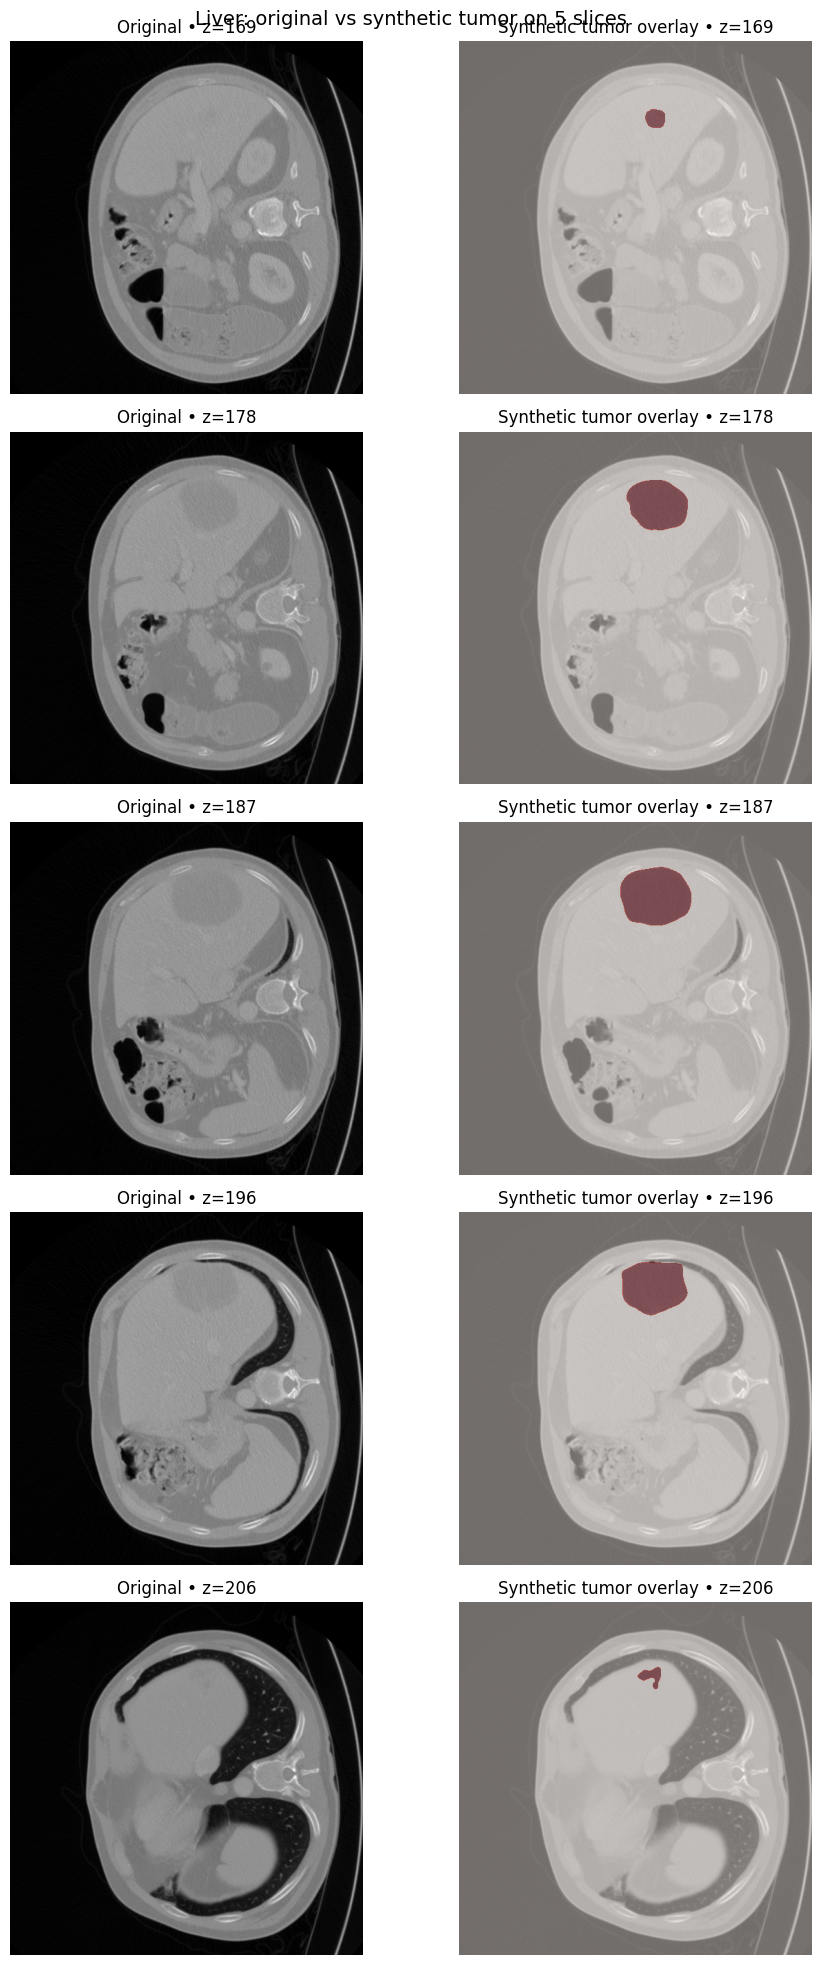

In [ ]:
image_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github\04_LiTS\img\liver_64.nii.gz"
label_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github\04_LiTS\label\liver_64.nii.gz"
num_slices = 5

plain = Compose([LoadImaged(keys=["image","label"]),
                 AddChanneld(keys=["image","label"]),
                 ToTensord(keys=["image","label"])])

synth = Compose([LoadImaged(keys=["image","label"]),
                 AddChanneld(keys=["image","label"]),
                 TumorGenerated(keys=["image","label"], prob=1.0),
                 ToTensord(keys=["image","label"])])

sample = {"image": image_path, "label": label_path}


orig = plain(sample)
img_o = orig["image"][0].numpy()     # (H,W,D)
lab_o = orig["label"][0].numpy()     # 0=bg, 1=liver

syn = synth(sample)
img_s = syn["image"][0].numpy()
lab_s = syn["label"][0].numpy()      # 0=bg, 1=liver, 2=tumor


liver_mask_z = np.where(np.any(lab_s == 1, axis=(0,1)))[0]
tumor_mask_z = np.where(np.any(lab_s == 2, axis=(0,1)))[0]
valid_z = np.intersect1d(liver_mask_z, tumor_mask_z)

if len(valid_z) == 0:
    raise RuntimeError("No slice with liver and synthetic tumor found.")


if len(valid_z) >= num_slices:
    zs = np.linspace(valid_z.min(), valid_z.max(), num_slices, dtype=int)
    zs = np.unique(zs)
else:
    zs = valid_z

rows = len(zs)
fig, axs = plt.subplots(rows, 2, figsize=(10, 4*rows))
if rows == 1:
    axs = np.array([axs])

for i, z in enumerate(zs):
   
    axs[i, 0].imshow(img_o[:, :, z], cmap="gray")
    axs[i, 0].set_title(f"Original • z={z}")
    axs[i, 0].axis("off")

    
    axs[i, 1].imshow(img_s[:, :, z], cmap="gray")
    axs[i, 1].imshow((lab_s[:, :, z] == 2), cmap="Reds", alpha=0.45)  
    axs[i, 1].set_title(f"Synthetic tumor overlay • z={z}")
    axs[i, 1].axis("off")

plt.suptitle(f"Liver: original vs synthetic tumor on {len(zs)} slices", fontsize=14)
plt.tight_layout()
plt.show()

# Network (Unet 3D)

In [ ]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,  # 0: background, 1: liver, 2:tumor
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm='instance',
).to(device)

# Training 

In [11]:
# Combined Loss Dice + CE
loss_func = DiceCELoss(to_onehot_y=True, softmax=True)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)

# Inference with sliding window
model_inferer = lambda x: sliding_window_inference(
    inputs=x, roi_size=roi_size, sw_batch_size=1, predictor=model, overlap=0.75, mode="gaussian" #paper's overlap: 0.75
)

In [12]:
def cal_dice(pred, true):
    intersection = np.sum(pred[true == 1]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true) + 1e-5)
    return dice

def cal_dice_nsd(pred, truth, spacing_mm=(1,1,1), tolerance=2):
    dice = cal_dice(pred, truth)
    surface_distances = compute_surface_distances(truth.astype(bool), pred.astype(bool), spacing_mm=spacing_mm)
    nsd = compute_surface_dice_at_tolerance(surface_distances, tolerance)
    return (dice, nsd)

In [13]:
def train_epoch(model, loader, optimizer, loss_func, device):
    model.train()
    epoch_loss = 0
    for batch_data in tqdm(loader, desc="Training", leave=False):
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(loader)

In [14]:
def val_epoch(model, loader, loss_func, device, model_inferer):
    model.eval()
    epoch_loss = 0

    dice_liver_all = []
    dice_tumor_all = []

    with torch.no_grad():
        for i, batch_data in enumerate(tqdm(loader, desc="Validation", leave=False)):
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)

            outputs = model_inferer(inputs)
            loss = loss_func(outputs, labels)
            epoch_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            trues = labels.squeeze(1).cpu().numpy()

            pixdim = batch_data['label_meta_dict']['pixdim'].cpu().numpy()
            spacing_mm = tuple(pixdim[0][1:4])

            for pred, true in zip(preds, trues):
                dice_liver, _ = cal_dice_nsd(pred == 1, true == 1, spacing_mm)
                dice_tumor, _ = cal_dice_nsd(pred == 2, true == 2, spacing_mm)
                dice_liver_all.append(dice_liver)
                dice_tumor_all.append(dice_tumor)

            del inputs, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

    dice_liver_all = np.array(dice_liver_all)
    dice_tumor_all = np.array(dice_tumor_all)
    mean_dice = (dice_liver_all.mean() + dice_tumor_all.mean()) / 2

    return epoch_loss / len(loader), mean_dice, [dice_liver_all.mean(), dice_tumor_all.mean()]

In [15]:
def run_training(
    model, train_loader, val_loader, optimizer, loss_func,
    model_inferer, device,
    max_epochs=50, val_every=1,
    logdir="./logs", save_ckpt=True,
    start_epoch=0, best_val_dice=-1,
    scheduler=None
):
    for epoch in range(start_epoch, max_epochs):
        print(f"\nEpoch {epoch+1}/{max_epochs}")

        train_loss = train_epoch(model, train_loader, optimizer, loss_func, device)
        print(f"  Train Loss: {train_loss:.4f}")

        # Save checkpoint
        if save_ckpt:
            ckpt_name = f"checkpoint_epoch_{epoch+1}.pt"
            ckpt_path = os.path.join(logdir, ckpt_name)
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_dice": best_val_dice,
            }, ckpt_path)
            print(f" Checkpoint saved: {ckpt_name}")

        # Validation
        if (epoch + 1) % val_every == 0:
            val_loss, val_dice, dice_classes = val_epoch(model, val_loader, loss_func, device, model_inferer)

            dice_liver = dice_classes[0]
            dice_tumor = dice_classes[1]

            print(f"  Val Loss: {val_loss:.4f} | Mean Dice: {val_dice:.4f}")
            print(f"     - Dice Liver (class 1):  {dice_liver:.4f}")
            print(f"     - Dice Tumor (class 2):  {dice_tumor:.4f}")

            # Save best model
            if val_dice > best_val_dice:
                best_val_dice = val_dice
                best_model_path = os.path.join(logdir, "best_model.pt")
                torch.save(model.state_dict(), best_model_path)
                print(f" Best model updated! Saved with Mean Dice: {val_dice:.4f}")

        if scheduler is not None:
            scheduler.step()

    print(" Training completed.")


### Training from Zero

In [ ]:
run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=loss_func,
    model_inferer=model_inferer,
    device=device,
    max_epochs=10,
    val_every=5,
    logdir=r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Checkpoint",
    save_ckpt=True,
    start_epoch=0,           # Start form the first epoch
    best_val_dice=-1        # no best model at the moment
)


Epoch 1/10


  Train Loss: 1.5897
 Checkpoint salvato: checkpoint_epoch_1.pt

Epoch 2/10


  Train Loss: 1.2498
 Checkpoint salvato: checkpoint_epoch_2.pt

Epoch 3/10


  Train Loss: 1.0974
 Checkpoint salvato: checkpoint_epoch_3.pt

Epoch 4/10


  Train Loss: 0.9957
 Checkpoint salvato: checkpoint_epoch_4.pt

Epoch 5/10


  Train Loss: 0.9314
 Checkpoint salvato: checkpoint_epoch_5.pt


  Val Loss: 0.8423 | Mean Dice: 0.3167
     - Dice Liver (class 1):  0.6310
     - Dice Tumor (class 2):  0.0023
 Best model aggiornato! Saved with Mean Dice: 0.3167

Epoch 6/10


  Train Loss: 0.9386
 Checkpoint salvato: checkpoint_epoch_6.pt

Epoch 7/10


  Train Loss: 0.8891
 Checkpoint salvato: checkpoint_epoch_7.pt

Epoch 8/10


  Train Loss: 0.8256
 Checkpoint salvato: checkpoint_epoch_8.pt

Epoch 9/10


  Train Loss: 0.8296
 Checkpoint salvato: checkpoint_epoch_9.pt

Epoch 10/10


  Train Loss: 0.8005
 Checkpoint salvato: checkpoint_epoch_10.pt


  Val Loss: 0.7095 | Mean Dice: 0.3989
     - Dice Liver (class 1):  0.7590
     - Dice Tumor (class 2):  0.0388
 Best model aggiornato! Saved with Mean Dice: 0.3989
 Training completato.


### Training from a Checkpoint

In [15]:
checkpoint_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Checkpoint\checkpoint_epoch_145.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
start_epoch = checkpoint["epoch"] + 1
best_val_dice = checkpoint["best_val_dice"]

In [ ]:
run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=loss_func,
    model_inferer=model_inferer,
    device=device,
    max_epochs=151,
    val_every=5,
    logdir=r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Checkpoint",
    save_ckpt=True,
    start_epoch=start_epoch,
    best_val_dice=best_val_dice
)


Epoch 146/151


  Train Loss: 0.5447
 Checkpoint saved: checkpoint_epoch_146.pt

Epoch 147/151


  Train Loss: 0.5441
 Checkpoint saved: checkpoint_epoch_147.pt

Epoch 148/151


  Train Loss: 0.5637
 Checkpoint saved: checkpoint_epoch_148.pt

Epoch 149/151


  Train Loss: 0.6188
 Checkpoint saved: checkpoint_epoch_149.pt

Epoch 150/151


  Train Loss: 0.5302
 Checkpoint saved: checkpoint_epoch_150.pt


  Val Loss: 0.4305 | Mean Dice: 0.5678
     - Dice Liver (class 1):  0.8471
     - Dice Tumor (class 2):  0.2885

Epoch 151/151


  Train Loss: 0.5977
 Checkpoint saved: checkpoint_epoch_151.pt
 Training completed.


# Evaluation

In [ ]:
# load best model
model.load_state_dict(torch.load(
    r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Checkpoint\best_model_145_04358_05760_0.84_031.pt",
    map_location=device
))
model.eval()


liver_dice_list = []
tumor_dice_list = []

with torch.no_grad():
    for batch_data in tqdm(val_loader, desc="Evaluating Best Model (Manual Dice)"):
        images = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        outputs = model_inferer(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        gts = labels.squeeze(1).cpu().numpy()

        pixdim = batch_data['label_meta_dict']['pixdim'].cpu().numpy()
        spacing_mm = tuple(pixdim[0][1:4])  # (dx, dy, dz)

        for pred, true in zip(preds, gts):
            liver_dice, _ = cal_dice_nsd(pred == 1, true == 1, spacing_mm)
            tumor_dice, _ = cal_dice_nsd(pred == 2, true == 2, spacing_mm)
            liver_dice_list.append(liver_dice)
            tumor_dice_list.append(tumor_dice)

# === Risultati aggregati
liver_dice_mean = np.mean(liver_dice_list)
tumor_dice_mean = np.mean(tumor_dice_list)
mean_dice = (liver_dice_mean + tumor_dice_mean) / 2

print("\n Results of the Best Model (Dice):")
print(f"   - Dice liver (Classe 1): {liver_dice_mean:.4f}")
print(f"   - Dice tumor (Classe 2): {tumor_dice_mean:.4f}")
print(f"   - Mean Dice: {mean_dice:.4f}")


Evaluating Best Model (Manual Dice): 100%|██████████| 22/22 [28:43<00:00, 78.36s/it] 


 Results of the Best Model (Dice):
   - Dice liver (Classe 1): 0.8413
   - Dice tumor (Classe 2): 0.3106
   - Mean Dice: 0.5760


## Single Data Evaluation

Mean softmax [bg, liver, tumor]: [0.9443 0.0529 0.0028]
GT unique: [0. 1. 2.] | Pred unique: [0 1 2]
Liver vox GT/Pred: 1387934 1601549
Tumor vox GT/Pred: 1638 23610
Dice liver (vol):  0.8740
Dice tumor (vol): 0.0382
Slice z=106 (source: GT-top)


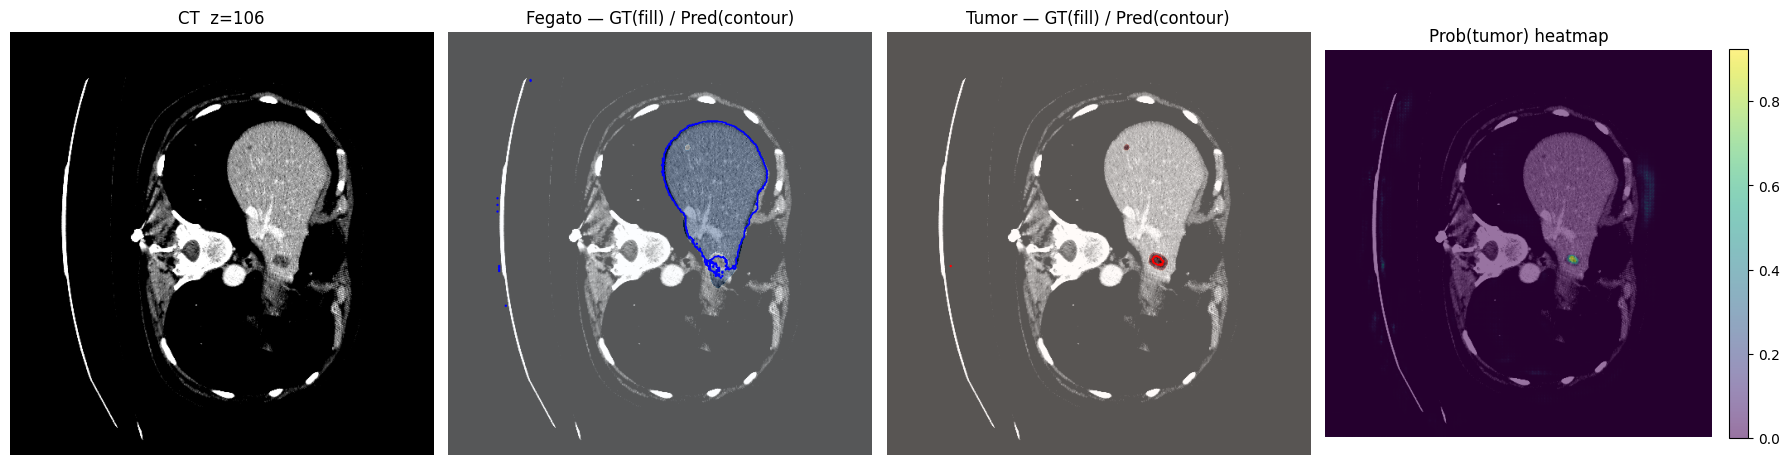

In [ ]:
image_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github\04_LiTS\img\liver_42.nii.gz"
label_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github\04_LiTS\label\liver_42.nii.gz"
model_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Checkpoint\best_model_145_04358_05760_0.84_031.pt"
roi_size   = (160, 160, 160)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


inference_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
            ScaleIntensityRanged(keys=["image"], a_min=-21, a_max=189, b_min=0.0, b_max=1.0, clip=True),
            SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[96, 96, 96]),
            ToTensord(keys=["image", "label"]),
        ]
    )


data_dict = [{"image": image_path, "label": label_path}]
ds = Dataset(data=data_dict, transform=inference_transform)
loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

model = UNet(
    spatial_dims=3, in_channels=1, out_channels=3,
    channels=(16,32,64,128,256), strides=(2,2,2,2), num_res_units=2, norm='instance'
).to(device)

state = torch.load(model_path, map_location=device)
if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)
model.eval()

# utils
def dice_bin(a: np.ndarray, b: np.ndarray) -> float:
    inter = (a & b).sum()
    s = a.sum() + b.sum()
    return float((2*inter)/(s+1e-7)) if s>0 else 0.0

def overlay_segmentation(ct_slice, mask_slice, title, cmap="Reds", alpha=0.4):
    plt.imshow(ct_slice, cmap="gray")
    plt.imshow(mask_slice.astype(np.float32), cmap=cmap, alpha=alpha, vmin=0, vmax=1)
    plt.title(title)
    plt.axis("off")

# Inference + visualization
with torch.no_grad():
    batch = next(iter(loader))
    img_t = batch["image"].to(device)             # [1,1,H,W,D]
    lab   = batch["label"].cpu().numpy().squeeze()  # [H,W,D]
    img_np= img_t.cpu().numpy()[0,0]

    # sliding-window inference 
    logits = sliding_window_inference(
        inputs=img_t, roi_size=roi_size, sw_batch_size=1,
        predictor=model, overlap=0.75, mode="gaussian"
    )
    probs = torch.softmax(logits, dim=1)          # [1,3,H,W,D]
    pred  = torch.argmax(probs, dim=1).cpu().numpy().squeeze()

    
    ch_means = probs.mean(dim=(0,2,3,4)).cpu().numpy()
    print("Mean softmax [bg, liver, tumor]:", np.round(ch_means, 4))
    print("GT unique:", np.unique(lab), "| Pred unique:", np.unique(pred))
    print("Liver vox GT/Pred:", int((lab==1).sum()), int((pred==1).sum()))
    print("Tumor vox GT/Pred:", int((lab==2).sum()), int((pred==2).sum()))

    dl = dice_bin(pred==1, lab==1)
    dt = dice_bin(pred==2, lab==2)
    print(f"Dice liver (vol):  {dl:.4f}")
    print(f"Dice tumor (vol): {dt:.4f}")

    gt_area   = (lab==2).sum(axis=(0,1))
    pr_area   = (pred==2).sum(axis=(0,1))
    if gt_area.sum() > 0:
        z = int(np.argmax(gt_area)); src = "GT-top"
    elif pr_area.sum() > 0:
        z = int(np.argmax(pr_area)); src = "Pred-top"
    else:
        z = lab.shape[-1]//2;        src = "middle (no tumor)"
    print(f"Slice z={z} (source: {src})")

    
    ct   = img_np[:,:,z]
    gt_l = (lab==1)[:,:,z]
    gt_t = (lab==2)[:,:,z]
    pr_l = (pred==1)[:,:,z]
    pr_t = (pred==2)[:,:,z]
    p_t  = probs[0,2].cpu().numpy()[:,:,z]  # prob(tumor)

    plt.figure(figsize=(18,6))

    # 1) CT
    plt.subplot(1,4,1)
    plt.imshow(ct, cmap="gray")
    plt.title(f"CT  z={z}")
    plt.axis("off")

    # 2) Overlay liver (GT vs Pred)
    plt.subplot(1,4,2)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_l, "Liver — GT(fill) / Pred(contour)", cmap="Blues", alpha=0.35)
    if pr_l.any():
        plt.contour(pr_l.astype(np.float32), levels=[0.5], colors='blue', linewidths=1.2)

    # 3) Overlay tumor (GT vs Pred)
    plt.subplot(1,4,3)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_t, "Tumor — GT(fill) / Pred(contour)", cmap="Reds", alpha=0.35)
    if pr_t.any():
        plt.contour(pr_t.astype(np.float32), levels=[0.5], colors='red', linewidths=1.2)

    # 4) Heatmap prob(tumor)
    plt.subplot(1,4,4)
    plt.imshow(ct, cmap="gray")
    im = plt.imshow(p_t, alpha=0.55)  # heatmap
    plt.title("Prob(tumor) heatmap")
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

### Liver 64

Mean softmax [bg, liver, tumor]: [0.9612 0.0349 0.0039]
GT unique: [0. 1. 2.] | Pred unique: [0 1 2]
Liver vox GT/Pred: 1980505 2172771
Tumor vox GT/Pred: 216273 219615
Dice liver (vol):  0.9181
Dice tumor (vol): 0.9205
Slice z=378 (source: GT-top)


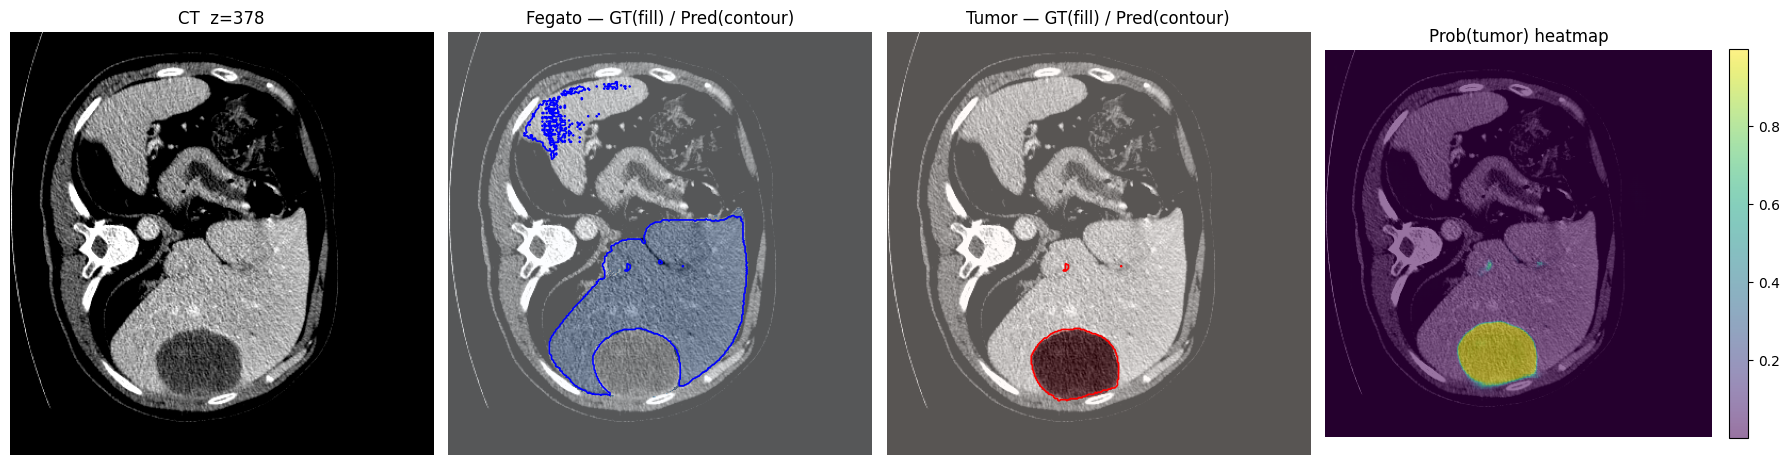

In [ ]:
image_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github\04_LiTS\img\liver_64.nii.gz"
label_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github\04_LiTS\label\liver_64.nii.gz"
model_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Checkpoint\best_model_145_04358_05760_0.84_031.pt"
roi_size   = (160, 160, 160)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


inference_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
            ScaleIntensityRanged(keys=["image"], a_min=-21, a_max=189, b_min=0.0, b_max=1.0, clip=True),
            SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[96, 96, 96]),
            ToTensord(keys=["image", "label"]),
        ]
    )


data_dict = [{"image": image_path, "label": label_path}]
ds = Dataset(data=data_dict, transform=inference_transform)
loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

model = UNet(
    spatial_dims=3, in_channels=1, out_channels=3,
    channels=(16,32,64,128,256), strides=(2,2,2,2), num_res_units=2, norm='instance'
).to(device)

state = torch.load(model_path, map_location=device)
if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)
model.eval()

# utils
def dice_bin(a: np.ndarray, b: np.ndarray) -> float:
    inter = (a & b).sum()
    s = a.sum() + b.sum()
    return float((2*inter)/(s+1e-7)) if s>0 else 0.0

def overlay_segmentation(ct_slice, mask_slice, title, cmap="Reds", alpha=0.4):
    plt.imshow(ct_slice, cmap="gray")
    plt.imshow(mask_slice.astype(np.float32), cmap=cmap, alpha=alpha, vmin=0, vmax=1)
    plt.title(title)
    plt.axis("off")

# Inference + visualization
with torch.no_grad():
    batch = next(iter(loader))
    img_t = batch["image"].to(device)             # [1,1,H,W,D]
    lab   = batch["label"].cpu().numpy().squeeze()  # [H,W,D]
    img_np= img_t.cpu().numpy()[0,0]

    # sliding-window inference 
    logits = sliding_window_inference(
        inputs=img_t, roi_size=roi_size, sw_batch_size=1,
        predictor=model, overlap=0.75, mode="gaussian"
    )
    probs = torch.softmax(logits, dim=1)          # [1,3,H,W,D]
    pred  = torch.argmax(probs, dim=1).cpu().numpy().squeeze()

    
    ch_means = probs.mean(dim=(0,2,3,4)).cpu().numpy()
    print("Mean softmax [bg, liver, tumor]:", np.round(ch_means, 4))
    print("GT unique:", np.unique(lab), "| Pred unique:", np.unique(pred))
    print("Liver vox GT/Pred:", int((lab==1).sum()), int((pred==1).sum()))
    print("Tumor vox GT/Pred:", int((lab==2).sum()), int((pred==2).sum()))

    dl = dice_bin(pred==1, lab==1)
    dt = dice_bin(pred==2, lab==2)
    print(f"Dice liver (vol):  {dl:.4f}")
    print(f"Dice tumor (vol): {dt:.4f}")

    gt_area   = (lab==2).sum(axis=(0,1))
    pr_area   = (pred==2).sum(axis=(0,1))
    if gt_area.sum() > 0:
        z = int(np.argmax(gt_area)); src = "GT-top"
    elif pr_area.sum() > 0:
        z = int(np.argmax(pr_area)); src = "Pred-top"
    else:
        z = lab.shape[-1]//2;        src = "middle (no tumor)"
    print(f"Slice z={z} (source: {src})")

    
    ct   = img_np[:,:,z]
    gt_l = (lab==1)[:,:,z]
    gt_t = (lab==2)[:,:,z]
    pr_l = (pred==1)[:,:,z]
    pr_t = (pred==2)[:,:,z]
    p_t  = probs[0,2].cpu().numpy()[:,:,z]  # prob(tumor)

    plt.figure(figsize=(18,6))

    # 1) CT
    plt.subplot(1,4,1)
    plt.imshow(ct, cmap="gray")
    plt.title(f"CT  z={z}")
    plt.axis("off")

    # 2) Overlay liver (GT vs Pred)
    plt.subplot(1,4,2)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_l, "Liver — GT(fill) / Pred(contour)", cmap="Blues", alpha=0.35)
    if pr_l.any():
        plt.contour(pr_l.astype(np.float32), levels=[0.5], colors='blue', linewidths=1.2)

    # 3) Overlay tumor (GT vs Pred)
    plt.subplot(1,4,3)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_t, "Tumor — GT(fill) / Pred(contour)", cmap="Reds", alpha=0.35)
    if pr_t.any():
        plt.contour(pr_t.astype(np.float32), levels=[0.5], colors='red', linewidths=1.2)

    # 4) Heatmap prob(tumor)
    plt.subplot(1,4,4)
    plt.imshow(ct, cmap="gray")
    im = plt.imshow(p_t, alpha=0.55)  # heatmap
    plt.title("Prob(tumor) heatmap")
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

### Liver 127

Mean softmax [bg, liver, tumor]: [9.757e-01 2.350e-02 8.000e-04]
GT unique: [0. 1. 2.] | Pred unique: [0 1 2]
Liver vox GT/Pred: 1631736 2140926
Tumor vox GT/Pred: 149 2901
Dice liver (vol):  0.8504
Dice tumor (vol): 0.0000
Slice z=442 (source: GT-top)


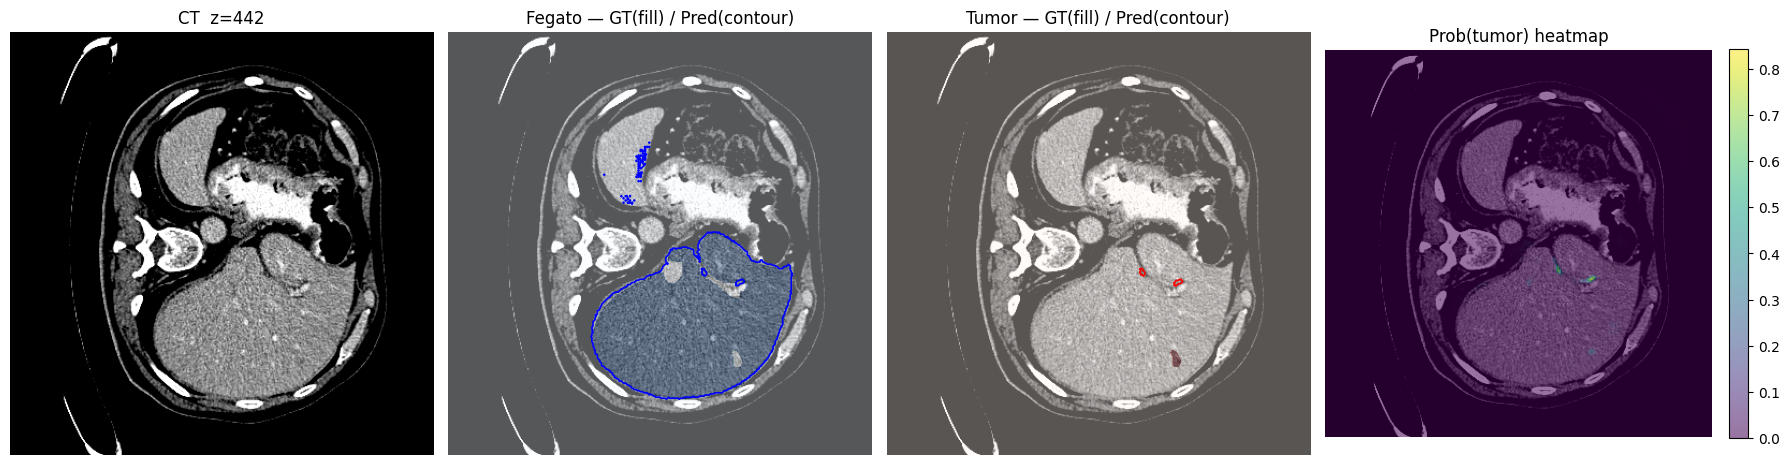

In [ ]:
image_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github\04_LiTS\img\liver_127.nii.gz"
label_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github\04_LiTS\label\liver_127.nii.gz"
model_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Checkpoint\best_model_145_04358_05760_0.84_031.pt"
roi_size   = (160, 160, 160)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


inference_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
            ScaleIntensityRanged(keys=["image"], a_min=-21, a_max=189, b_min=0.0, b_max=1.0, clip=True),
            SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[96, 96, 96]),
            ToTensord(keys=["image", "label"]),
        ]
    )


data_dict = [{"image": image_path, "label": label_path}]
ds = Dataset(data=data_dict, transform=inference_transform)
loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

model = UNet(
    spatial_dims=3, in_channels=1, out_channels=3,
    channels=(16,32,64,128,256), strides=(2,2,2,2), num_res_units=2, norm='instance'
).to(device)

state = torch.load(model_path, map_location=device)
if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)
model.eval()

# utils
def dice_bin(a: np.ndarray, b: np.ndarray) -> float:
    inter = (a & b).sum()
    s = a.sum() + b.sum()
    return float((2*inter)/(s+1e-7)) if s>0 else 0.0

def overlay_segmentation(ct_slice, mask_slice, title, cmap="Reds", alpha=0.4):
    plt.imshow(ct_slice, cmap="gray")
    plt.imshow(mask_slice.astype(np.float32), cmap=cmap, alpha=alpha, vmin=0, vmax=1)
    plt.title(title)
    plt.axis("off")

# Inference + visualization
with torch.no_grad():
    batch = next(iter(loader))
    img_t = batch["image"].to(device)             # [1,1,H,W,D]
    lab   = batch["label"].cpu().numpy().squeeze()  # [H,W,D]
    img_np= img_t.cpu().numpy()[0,0]

    # sliding-window inference 
    logits = sliding_window_inference(
        inputs=img_t, roi_size=roi_size, sw_batch_size=1,
        predictor=model, overlap=0.75, mode="gaussian"
    )
    probs = torch.softmax(logits, dim=1)          # [1,3,H,W,D]
    pred  = torch.argmax(probs, dim=1).cpu().numpy().squeeze()

    
    ch_means = probs.mean(dim=(0,2,3,4)).cpu().numpy()
    print("Mean softmax [bg, liver, tumor]:", np.round(ch_means, 4))
    print("GT unique:", np.unique(lab), "| Pred unique:", np.unique(pred))
    print("Liver vox GT/Pred:", int((lab==1).sum()), int((pred==1).sum()))
    print("Tumor vox GT/Pred:", int((lab==2).sum()), int((pred==2).sum()))

    dl = dice_bin(pred==1, lab==1)
    dt = dice_bin(pred==2, lab==2)
    print(f"Dice liver (vol):  {dl:.4f}")
    print(f"Dice tumor (vol): {dt:.4f}")

    gt_area   = (lab==2).sum(axis=(0,1))
    pr_area   = (pred==2).sum(axis=(0,1))
    if gt_area.sum() > 0:
        z = int(np.argmax(gt_area)); src = "GT-top"
    elif pr_area.sum() > 0:
        z = int(np.argmax(pr_area)); src = "Pred-top"
    else:
        z = lab.shape[-1]//2;        src = "middle (no tumor)"
    print(f"Slice z={z} (source: {src})")

    
    ct   = img_np[:,:,z]
    gt_l = (lab==1)[:,:,z]
    gt_t = (lab==2)[:,:,z]
    pr_l = (pred==1)[:,:,z]
    pr_t = (pred==2)[:,:,z]
    p_t  = probs[0,2].cpu().numpy()[:,:,z]  # prob(tumor)

    plt.figure(figsize=(18,6))

    # 1) CT
    plt.subplot(1,4,1)
    plt.imshow(ct, cmap="gray")
    plt.title(f"CT  z={z}")
    plt.axis("off")

    # 2) Overlay liver (GT vs Pred)
    plt.subplot(1,4,2)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_l, "Liver — GT(fill) / Pred(contour)", cmap="Blues", alpha=0.35)
    if pr_l.any():
        plt.contour(pr_l.astype(np.float32), levels=[0.5], colors='blue', linewidths=1.2)

    # 3) Overlay tumor (GT vs Pred)
    plt.subplot(1,4,3)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_t, "Tumor — GT(fill) / Pred(contour)", cmap="Reds", alpha=0.35)
    if pr_t.any():
        plt.contour(pr_t.astype(np.float32), levels=[0.5], colors='red', linewidths=1.2)

    # 4) Heatmap prob(tumor)
    plt.subplot(1,4,4)
    plt.imshow(ct, cmap="gray")
    im = plt.imshow(p_t, alpha=0.55)  # heatmap
    plt.title("Prob(tumor) heatmap")
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

### Liver 17 

Mean softmax [bg, liver, tumor]: [0.9726 0.0262 0.0012]
GT unique: [0. 1. 2.] | Pred unique: [0 1 2]
Liver vox GT/Pred: 1587948 2161044
Tumor vox GT/Pred: 16747 30996
Dice liver (vol):  0.8338
Dice tumor (vol): 0.5862
Slice z=323 (source: GT-top)


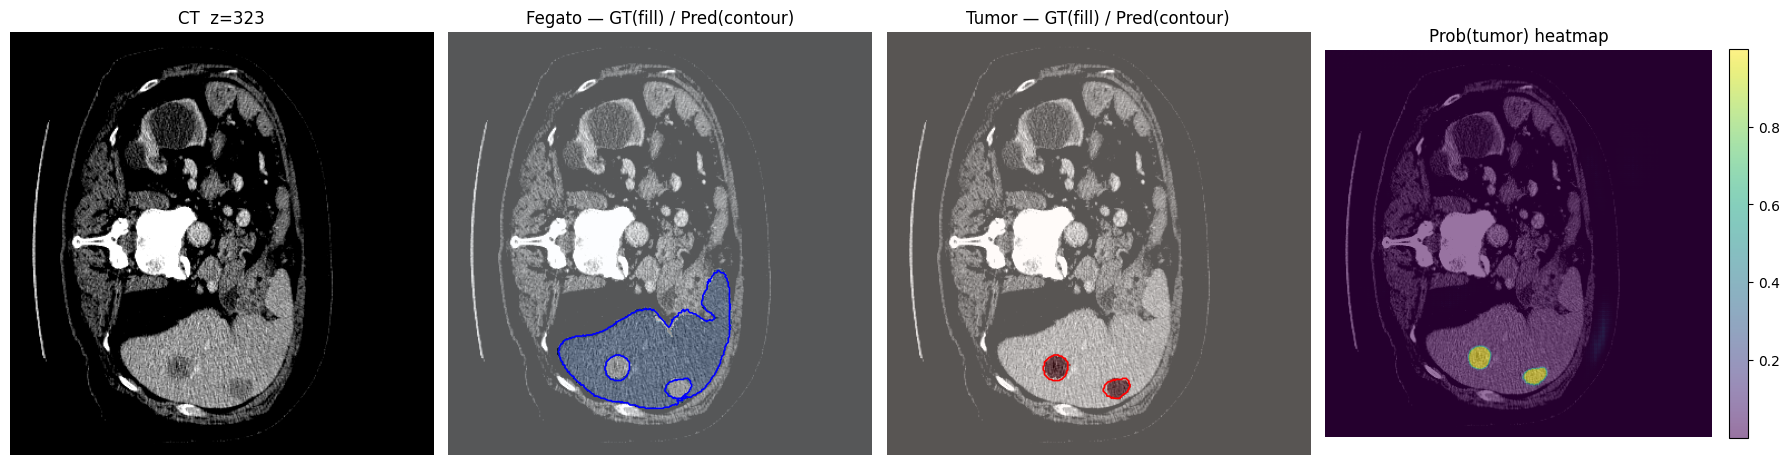

In [ ]:
image_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github\04_LiTS\img\liver_17.nii.gz"
label_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Dataset_github\04_LiTS\label\liver_17.nii.gz"
model_path = r"C:\Users\franc\OneDrive\Desktop\Liver_tumor_Synthetic\Checkpoint\best_model_145_04358_05760_0.84_031.pt"
roi_size   = (160, 160, 160)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


inference_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
            ScaleIntensityRanged(keys=["image"], a_min=-21, a_max=189, b_min=0.0, b_max=1.0, clip=True),
            SpatialPadd(keys=["image", "label"], mode=["minimum", "constant"], spatial_size=[96, 96, 96]),
            ToTensord(keys=["image", "label"]),
        ]
    )


data_dict = [{"image": image_path, "label": label_path}]
ds = Dataset(data=data_dict, transform=inference_transform)
loader = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

model = UNet(
    spatial_dims=3, in_channels=1, out_channels=3,
    channels=(16,32,64,128,256), strides=(2,2,2,2), num_res_units=2, norm='instance'
).to(device)

state = torch.load(model_path, map_location=device)
if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)
model.eval()

# utils
def dice_bin(a: np.ndarray, b: np.ndarray) -> float:
    inter = (a & b).sum()
    s = a.sum() + b.sum()
    return float((2*inter)/(s+1e-7)) if s>0 else 0.0

def overlay_segmentation(ct_slice, mask_slice, title, cmap="Reds", alpha=0.4):
    plt.imshow(ct_slice, cmap="gray")
    plt.imshow(mask_slice.astype(np.float32), cmap=cmap, alpha=alpha, vmin=0, vmax=1)
    plt.title(title)
    plt.axis("off")

# Inference + visualization
with torch.no_grad():
    batch = next(iter(loader))
    img_t = batch["image"].to(device)             # [1,1,H,W,D]
    lab   = batch["label"].cpu().numpy().squeeze()  # [H,W,D]
    img_np= img_t.cpu().numpy()[0,0]

    # sliding-window inference 
    logits = sliding_window_inference(
        inputs=img_t, roi_size=roi_size, sw_batch_size=1,
        predictor=model, overlap=0.75, mode="gaussian"
    )
    probs = torch.softmax(logits, dim=1)          # [1,3,H,W,D]
    pred  = torch.argmax(probs, dim=1).cpu().numpy().squeeze()

    
    ch_means = probs.mean(dim=(0,2,3,4)).cpu().numpy()
    print("Mean softmax [bg, liver, tumor]:", np.round(ch_means, 4))
    print("GT unique:", np.unique(lab), "| Pred unique:", np.unique(pred))
    print("Liver vox GT/Pred:", int((lab==1).sum()), int((pred==1).sum()))
    print("Tumor vox GT/Pred:", int((lab==2).sum()), int((pred==2).sum()))

    dl = dice_bin(pred==1, lab==1)
    dt = dice_bin(pred==2, lab==2)
    print(f"Dice liver (vol):  {dl:.4f}")
    print(f"Dice tumor (vol): {dt:.4f}")

    gt_area   = (lab==2).sum(axis=(0,1))
    pr_area   = (pred==2).sum(axis=(0,1))
    if gt_area.sum() > 0:
        z = int(np.argmax(gt_area)); src = "GT-top"
    elif pr_area.sum() > 0:
        z = int(np.argmax(pr_area)); src = "Pred-top"
    else:
        z = lab.shape[-1]//2;        src = "middle (no tumor)"
    print(f"Slice z={z} (source: {src})")

    
    ct   = img_np[:,:,z]
    gt_l = (lab==1)[:,:,z]
    gt_t = (lab==2)[:,:,z]
    pr_l = (pred==1)[:,:,z]
    pr_t = (pred==2)[:,:,z]
    p_t  = probs[0,2].cpu().numpy()[:,:,z]  # prob(tumor)

    plt.figure(figsize=(18,6))

    # 1) CT
    plt.subplot(1,4,1)
    plt.imshow(ct, cmap="gray")
    plt.title(f"CT  z={z}")
    plt.axis("off")

    # 2) Overlay liver (GT vs Pred)
    plt.subplot(1,4,2)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_l, "Liver — GT(fill) / Pred(contour)", cmap="Blues", alpha=0.35)
    if pr_l.any():
        plt.contour(pr_l.astype(np.float32), levels=[0.5], colors='blue', linewidths=1.2)

    # 3) Overlay tumor (GT vs Pred)
    plt.subplot(1,4,3)
    plt.imshow(ct, cmap="gray")
    overlay_segmentation(ct, gt_t, "Tumor — GT(fill) / Pred(contour)", cmap="Reds", alpha=0.35)
    if pr_t.any():
        plt.contour(pr_t.astype(np.float32), levels=[0.5], colors='red', linewidths=1.2)

    # 4) Heatmap prob(tumor)
    plt.subplot(1,4,4)
    plt.imshow(ct, cmap="gray")
    im = plt.imshow(p_t, alpha=0.55)  # heatmap
    plt.title("Prob(tumor) heatmap")
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()